# <center>Appendix</center> Dane Jordan
## Project: Part 1

### Copy S3 datasets to my S3
Using `AWS CLI` I copied the 1GB and 10GB datasets to my S3:
```
aws s3 cp s3://uwdb/tpch/uniform/1GB s3://data516-drjordan/project_part_1/1GB/ --recursive
aws s3 cp s3://uwdb/tpch/uniform/10GB s3://data516-drjordan/project_part_1/10GB/ --recursive
aws s3 cp s3://uwdb/tpch/uniform/100GB s3://data516-drjordan/project_part_1/100GB/ --recursive
```

### Import necessary libraries

In [1]:
import boto3
import math
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import seaborn as sns

%matplotlib inline


### Link S3 to both client and resource calls and functionalize calls to S3 files
While I didn't need both, I decided to experiment with the two since I was new to `boto3` and did not know which would be more efficient for getting the data to parse it. I functionalized the client and resource for both "reading" S3 into a DataFrame as well as downloading files and then reading them into a DataFrame.

Ultimately the differences between client and resource were marginal. The difference in time to get the data into a DataFrame was much faster by downloading the data rather than reading it from S3. You will see below that I proceeded to download all of the files using the `resource_download` function.

In [2]:
client = boto3.client('s3')
resource = boto3.resource('s3')


def client_s3_read(data_set, table_name):
    
    obj = client.get_object(Bucket='data516-drjordan',
                            Key='project_part_1/' + data_set + 'GB/' + table_name + '.tbl')['Body']
    obj_cols = client.get_object(Bucket='data516-drjordan',
                                 Key='project_part_1/' + data_set + 'GB/' + table_name + '.tbl')['Body']
    cols = pd.read_table(obj_cols, sep='|', header=None, index_col=False, nrows=1).columns
    return pd.read_table(obj, sep='|', header=None, index_col=False, usecols=cols[:-1])


def resource_s3_read(data_set, table_name):
    
    obj = resource.Object('data516-drjordan',
                          'project_part_1/' + data_set + 'GB/' + table_name + '.tbl').get()['Body']
    obj_cols = resource.Object('data516-drjordan',
                               'project_part_1/' + data_set + 'GB/' + table_name + '.tbl').get()['Body']
    cols = pd.read_table(obj_cols, sep='|', header=None, index_col=False, nrows=1).columns
    return pd.read_table(obj, sep='|', header=None, index_col=False, usecols=cols[:-1])


def client_download(data_set, table_name):
    
    client.download_file('data516-drjordan',
                         'project_part_1/' + data_set + 'GB/' + table_name + '.tbl',
                         data_set + 'GB/' + table_name + '.tbl')

    
def resource_download(data_set, table_name):
    
    resource.Bucket('data516-drjordan').download_file('project_part_1/' + data_set + 'GB/' + table_name + '.tbl',
                                                      data_set + 'GB/' + table_name + '.tbl')

    
def download_read(data_set, table_name):
    
    cols = pd.read_table(data_set + 'GB/' + table_name + '.tbl', sep='|', header=None, index_col=False, nrows=1).columns
    return pd.read_table(data_set + 'GB/' + table_name + '.tbl', sep='|', header=None, index_col=False, usecols=cols[:-1])


### Download the 1GB and 10GB datasets
The code below takes approximately 30 minutes to run.

In [3]:
# for i in ['customer', 'lineitem', 'nation', 'orders', 'part', 'partsupp', 'region', 'supplier']:
#     resource_download('1', i)
#     resource_download('10', i)


### Research Questions:
_Unless explicitly noted, when multiple files are ingested, they are assumed to be evenly distributed (number of rows) in chunks such that a table split into 4 separate files would be the first 1/4 rows in the first file, the second 1/4 rows in the second file, etc._

1. __Does ingesting data in parallel decrease ingestion time?__  
While I assume that this is true based on what I have learned regarding parallel DBMSs, I believe it prudent that it still be tested in practice before investigating further questions. To test this, I will compare a 2-node cluster ingesting 1 file against a 2-node cluster ingesting 2 files.

  1. 1 file, 2-nodes
  2. 2 files, 2-nodes

2. __Is the ingestion time using unevenly balanced files longer than that of evenly balanced files, assuming the same number of files and same number of nodes on a cluster? Also, is the ingestion time using unevenly balanced files shorter than that of a single file with the same number of nodes on a cluster?__
For this I will compare the ingestion times when the data is split into 2 evenly distributed files and 2 unevenly distributed files using a 2-node cluster. For this I will compare it with the ingestion time from RQ1 using 1 file and a 2-node cluster.

  1. 2 uneven files, 2-nodes
  2. compare A with RQ1.B
  3. compare A with RQ1.A

3. __Does increasing the number of files beyond the number of nodes on a cluster decrease ingestion time?__  
For this I will compare the ingestion times when the data is split into 2 files and 4 files, both recorded on a 2-node cluster.

  1. 4 files, 2-nodes
  2. compare A with RQ1.B

4. __Does increasing the number of nodes on a cluster beyond the number of files decrease ingestion time?__  
For this I will compare the ingestion times when the data is split into 2 files running on a 2-node cluster versus running on a 4-node cluster.

  1. 2 files, 4-nodes
  2. compare A with RQ1.B

5. __Does ingesting an odd number of files such that the number of files is 1 less than the number of nodes on a cluster take longer than ingesting the same number of files as there are nodes on a cluster? Conversely, does ingesting an odd number of files such that the number of files is 1 greater than the number of nodes on a cluster take longer than ingesting the same number of files as there are nodes on a cluster?__  
For this I willl compare the ingestion times when the data is split into 15 files and 16 files, both recorded on a 16-node cluster.

  1. 15 files, 16-nodes
  2. 16 files, 16-nodes
  3. 17 files, 16-nodes

### Splitting the files
For the purposes of testing ingestion times, we will use the `lineitem` table from the 10GB dataset as this is the largest table and should show more drastic changes in ingestion times should they change.

In [4]:
def split_files(file_in, file_out, num_files):
    
    num_lines = sum(1 for line in open(file_in))
    lines_per_file = math.ceil(num_lines / num_files)
    
    with open(file_in, 'rb') as fin:
        fout = open(file_out + '0.tbl', 'wb')
        for i, line in enumerate(fin):
            fout.write(line)
            if (i + 1) % lines_per_file == 0:
                fout.close()
                if (i + 1) != num_lines:
                    fout = open(file_out + '%d.tbl' % (i / lines_per_file + 1), 'wb')
        fout.close()

        
def split_2_files_alternating(file_in, file_out):
    
    with open(file_in, 'rb') as fin:
        fout1 = open(file_out + '0.tbl', 'wb')
        fout2 = open(file_out + '1.tbl', 'wb')
        for i, line in enumerate(fin):
            if (i % 2) == 0:
                fout1.write(line)
            else:
                fout2.write(line)
        fout1.close()
        fout2.close()

        
def split_2_files_random(file_in, file_out):
    
    with open(file_in, 'rb') as fin:
        fout1 = open(file_out + '0.tbl', 'wb')
        fout2 = open(file_out + '1.tbl', 'wb')
        for i, line in enumerate(fin):
            rand_num = random.randint(0, 1)
            if rand_num == 0:
                fout1.write(line)
            else:
                fout2.write(line)
        fout1.close()
        fout2.close()


In [5]:
# file_in = '10GB/lineitem.tbl'

# # even file splits
# for i in [2, 4, 8, 15, 16, 17, 32]:
#     file_out = '10GB/' + str(i) + '_files/lineitem'
#     split_files(file_in, file_out, i)

# # alternating 2 file split
# split_2_files_alternating(file_in, '10GB/2_files_alternating/lineitem')

# # random 2 file split
# split_2_files_random(file_in, '10GB/2_files_random/lineitem')

# # uneven file split
# split_files(file_in, '10GB/2_files_uneven/lineitem', 1.5)


### Creating S3 folders and uploading files
While it is quite interesting using `boto3` to create directories and upload files, it seems as if using `AWS CLI` is still much faster at transferring files to S3. The code below does in fact create the directories and upload the files, however, the following `AWS CLI` commands were used to speed up this process:
```
aws s3 cp 2_files s3://data516-drjordan/project_part_1/split_files/2_files/ --recursive
aws s3 cp 2_files_alternating s3://data516-drjordan/project_part_1/split_files/2_files_alternating/ --recursive
aws s3 cp 2_files_random s3://data516-drjordan/project_part_1/split_files/2_files_random/ --recursive
aws s3 cp 2_files_uneven s3://data516-drjordan/project_part_1/split_files/2_files_uneven/ --recursive
aws s3 cp 4_files s3://data516-drjordan/project_part_1/split_files/4_files/ --recursive
aws s3 cp 8_files s3://data516-drjordan/project_part_1/split_files/8_files/ --recursive
aws s3 cp 15_files s3://data516-drjordan/project_part_1/split_files/15_files/ --recursive
aws s3 cp 16_files s3://data516-drjordan/project_part_1/split_files/16_files/ --recursive
aws s3 cp 17_files s3://data516-drjordan/project_part_1/split_files/17_files/ --recursive
aws s3 cp 32_files s3://data516-drjordan/project_part_1/split_files/32_files/ --recursive
```

In [ ]:
def upload_files(dirpath, s3path, bucket):
    
    for root, dirs, files in os.walk(dirpath):
        for file in files:
            client.upload_file(os.path.join(root, file), bucket, s3path + file)
            

In [7]:
# folder_name = ['2_files',
#                '2_files_alternating',
#                '2_files_random',
#                '2_files_uneven',
#                '4_files',
#                '8_files',
#                '15_files',
#                '16_files',
#                '17_files',
#                '32_files']

# # loop through the various folders and upload the files within each folder
# for i in folder_name:
#     upload_files('10GB/' + i + '/',
#                  'project_part_1/split_files/' + i + '/',
#                  'data516-drjordan')


### The following SQL commands were used to obtain ingestion times

```SQL
CREATE TABLE lineitem(
L_OrderKey int ,
L_PartKey int ,
L_SuppKey int ,
L_LineNumber int ,
L_Quantity int ,
L_ExtendedPrice decimal(13, 2) ,
L_Discount decimal(13, 2) ,
L_Tax decimal(13, 2) ,
L_ReturnFlag varchar(64) ,
L_LineStatus varchar(64) ,
L_ShipDate datetime ,
L_CommitDate datetime ,
L_ReceiptDate datetime ,
L_ShipInstruct varchar(64) ,
L_ShipMode varchar(64) ,
L_Comment varchar(64) ,
skip varchar(64)
);

DROP TABLE lineitem;

COPY lineitem FROM 's3://data516-drjordan/project_part_1/10GB/lineitem.tbl' CREDENTIALS 'aws_iam_role=arn:aws:iam::************:role/myRedshiftRole' delimiter '|';
COPY lineitem FROM 's3://data516-drjordan/project_part_1/split_files/2_files/' CREDENTIALS 'aws_iam_role=arn:aws:iam::************:role/myRedshiftRole' delimiter '|';
COPY lineitem FROM 's3://data516-drjordan/project_part_1/split_files/2_files_alternating/' CREDENTIALS 'aws_iam_role=arn:aws:iam::************:role/myRedshiftRole' delimiter '|';
COPY lineitem FROM 's3://data516-drjordan/project_part_1/split_files/2_files_random/' CREDENTIALS 'aws_iam_role=arn:aws:iam::************:role/myRedshiftRole' delimiter '|';
COPY lineitem FROM 's3://data516-drjordan/project_part_1/split_files/2_files_uneven/' CREDENTIALS 'aws_iam_role=arn:aws:iam::************:role/myRedshiftRole' delimiter '|';
COPY lineitem FROM 's3://data516-drjordan/project_part_1/split_files/4_files/' CREDENTIALS 'aws_iam_role=arn:aws:iam::************:role/myRedshiftRole' delimiter '|';
COPY lineitem FROM 's3://data516-drjordan/project_part_1/split_files/8_files/' CREDENTIALS 'aws_iam_role=arn:aws:iam::************:role/myRedshiftRole' delimiter '|';
COPY lineitem FROM 's3://data516-drjordan/project_part_1/split_files/15_files/' CREDENTIALS 'aws_iam_role=arn:aws:iam::************:role/myRedshiftRole' delimiter '|';
COPY lineitem FROM 's3://data516-drjordan/project_part_1/split_files/16_files/' CREDENTIALS 'aws_iam_role=arn:aws:iam::************:role/myRedshiftRole' delimiter '|';
COPY lineitem FROM 's3://data516-drjordan/project_part_1/split_files/17_files/' CREDENTIALS 'aws_iam_role=arn:aws:iam::************:role/myRedshiftRole' delimiter '|';
COPY lineitem FROM 's3://data516-drjordan/project_part_1/split_files/32_files/' CREDENTIALS 'aws_iam_role=arn:aws:iam::************:role/myRedshiftRole' delimiter '|';
```

### Import ingestion time data and answer RQs

In [2]:
ingest_times = pd.read_csv('ingest_times.csv')
ingest_times_transpose = ingest_times.transpose().reset_index()
ingest_times_transpose.columns = ingest_times_transpose.iloc[0]
ingest_times_transpose = ingest_times_transpose.drop(0).reset_index(drop=True)


#### RQ1

In [9]:
ingest_times_transpose[[0, 1, 2]].drop([1, 2, 3, 4])


,data,1_file,2_files
0,2-nodes,285,186


#### RQ2

In [10]:
ingest_times_transpose[[0, 2, 5]].drop([1, 2, 3, 4])


,data,2_files,2_files_uneven
0,2-nodes,186,220


#### RQ3

In [11]:
ingest_times_transpose[[0, 1, 5]].drop([1, 2, 3, 4])


,data,1_file,2_files_uneven
0,2-nodes,285,220


#### RQ4

In [12]:
ingest_times_transpose[[0, 2, 6]].drop([1, 2, 3, 4])


,data,2_files,4_files
0,2-nodes,186,186


#### RQ5

In [13]:
ingest_times_transpose[[0, 2]].drop([2, 3, 4])


,data,2_files
0,2-nodes,186
1,4-nodes,159


#### RQ6

In [14]:
ingest_times_transpose[[0, 8, 9, 10]].drop([0, 1, 2, 4])


,data,15_files,16_files,17_files
3,16-nodes,41,41,51


### Import ingestion time data and visualize

In [15]:
ingest_times


,data,2-nodes,4-nodes,8-nodes,16-nodes,32-nodes
0,1_file,285,273,268,261,260
1,2_files,186,159,142,136,136
2,2_files_alternating,186,158,140,138,137
3,2_files_random,186,157,146,136,134
4,2_files_uneven,220,196,185,178,177
5,4_files,186,105,87,78,74
6,8_files,184,112,61,52,48
7,15_files,195,113,71,41,34
8,16_files,188,110,70,41,34
9,17_files,184,114,81,51,33


In [16]:
ingest_times_transpose


,data,1_file,2_files,2_files_alternating,2_files_random,2_files_uneven,4_files,8_files,15_files,16_files,17_files,32_files
0,2-nodes,285,186,186,186,220,186,184,195,188,184,185
1,4-nodes,273,159,158,157,196,105,112,113,110,114,110
2,8-nodes,268,142,140,146,185,87,61,71,70,81,69
3,16-nodes,261,136,138,136,178,78,52,41,41,51,51
4,32-nodes,260,136,137,134,177,74,48,34,34,33,32


In [5]:
def plot_heatmap(data, title_size=16, axis_size=14, tick_size=14, annotation_size=14):
    
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(data, annot=True, fmt='d', annot_kws={'size': annotation_size}, cbar=False, ax=ax)
    sns.plt.title('Ingestion Times (s)', fontsize=title_size)
    sns.plt.xlabel('# of nodes', fontsize=axis_size)
    sns.plt.xticks(fontsize=tick_size)
    sns.plt.ylabel('# of files', fontsize=axis_size)
    sns.plt.yticks(fontsize=tick_size, rotation='horizontal')
    plt.tight_layout()
    
    
def plot_line(data, title_size=16, axis_size=14, tick_size=14, legend_size=14):
    
    data.plot(x='data', figsize=(12,8), fontsize=tick_size)
#     plt.title('Ingestion Times (s)', fontsize=title_size)
    plt.xlabel('# of files or nodes', fontsize=axis_size)
    plt.xticks(range(len(data['data'])), data['data'], rotation=45)
    plt.ylabel('ingestion time (s)', fontsize=axis_size)
    plt.legend(fontsize=legend_size)
    plt.tight_layout()
    
    
def plot_bar(data, title_size=16, axis_size=14, tick_size=14, legend_size=14):
    
    data.plot(x='data', kind='bar', figsize=(12,8), fontsize=tick_size)
    plt.title('Ingestion Times (s)', fontsize=title_size)
    plt.xlabel('# of files or nodes', fontsize=axis_size)
    plt.xticks(rotation=45)
    plt.ylabel('ingestion time (s)', fontsize=axis_size)
    plt.legend(fontsize=legend_size)
    plt.tight_layout()


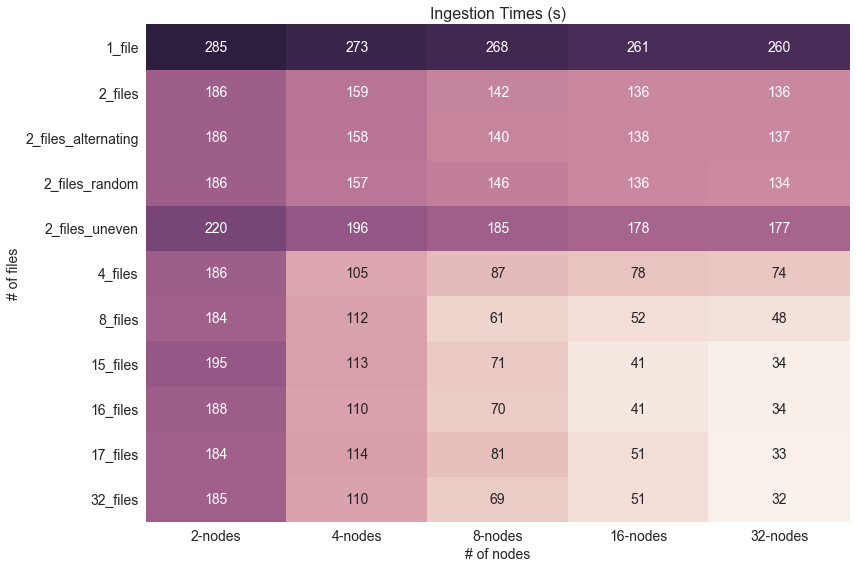

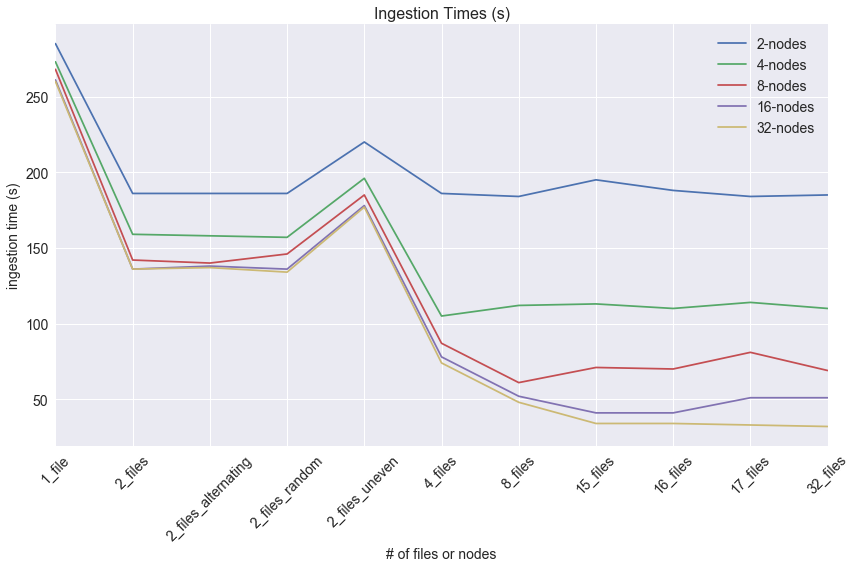

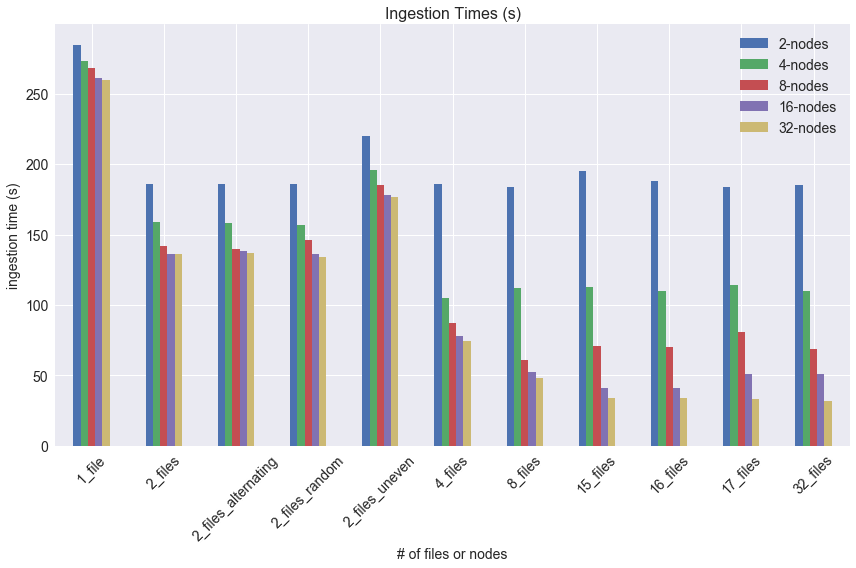

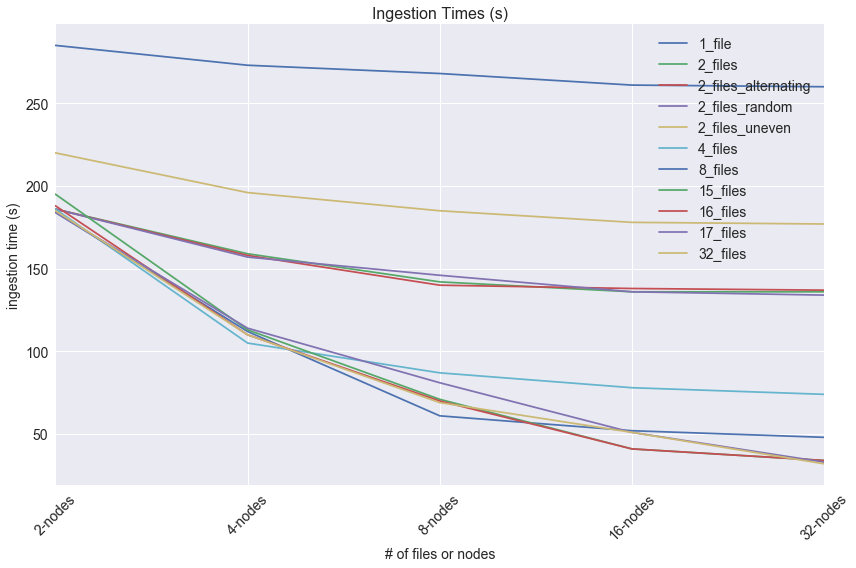

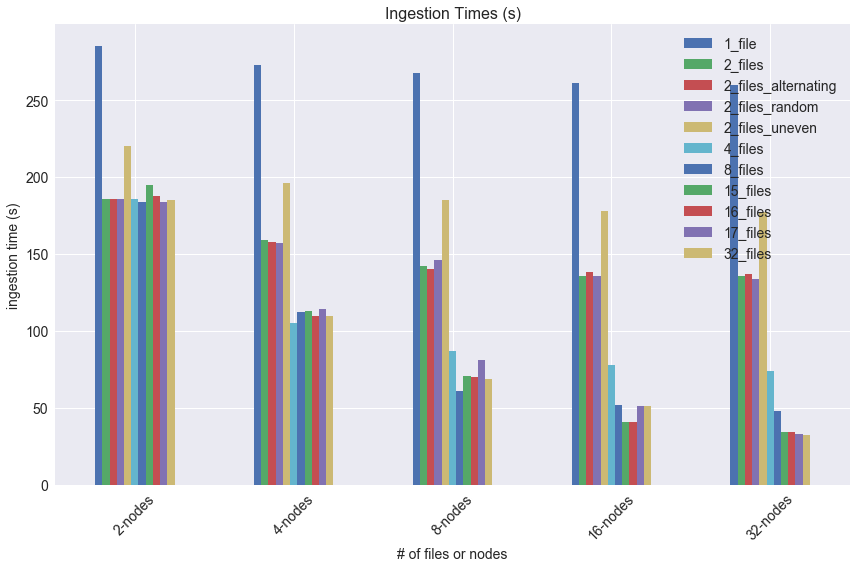

In [18]:
plot_heatmap(ingest_times.set_index('data'))
plot_line(ingest_times)
plot_bar(ingest_times)
plot_line(ingest_times_transpose)
plot_bar(ingest_times_transpose)


### Visualize data without the special cases (2_files, 15_files and 17_files)

In [19]:
ingest_times.drop([2, 3, 4, 7, 9])


,data,2-nodes,4-nodes,8-nodes,16-nodes,32-nodes
0,1_file,285,273,268,261,260
1,2_files,186,159,142,136,136
5,4_files,186,105,87,78,74
6,8_files,184,112,61,52,48
8,16_files,188,110,70,41,34
10,32_files,185,110,69,51,32


In [20]:
ingest_times_transpose[[0, 1, 2, 6, 7, 9, 11]]


,data,1_file,2_files,4_files,8_files,16_files,32_files
0,2-nodes,285,186,186,184,188,185
1,4-nodes,273,159,105,112,110,110
2,8-nodes,268,142,87,61,70,69
3,16-nodes,261,136,78,52,41,51
4,32-nodes,260,136,74,48,34,32


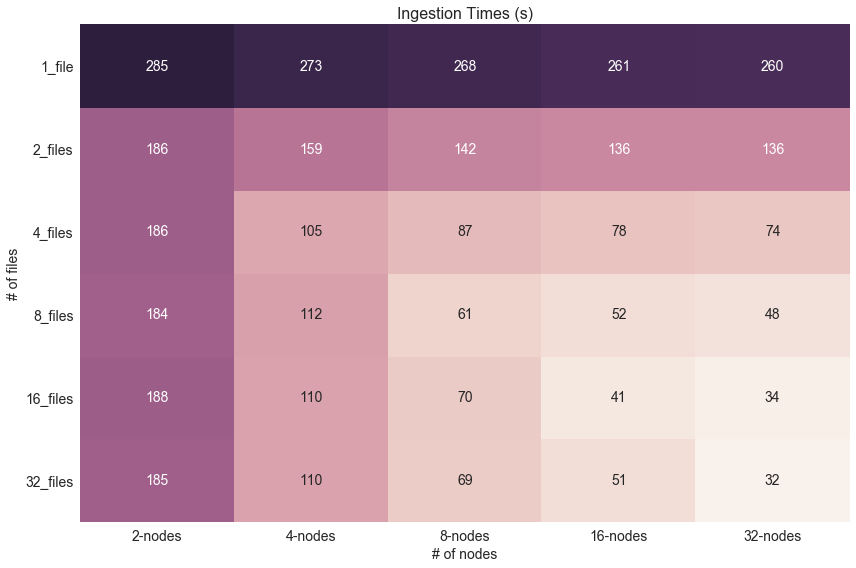

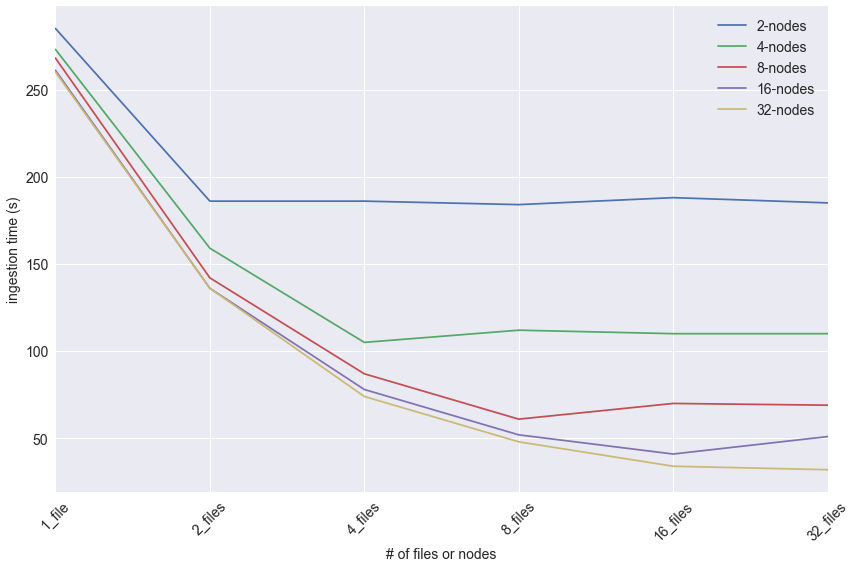

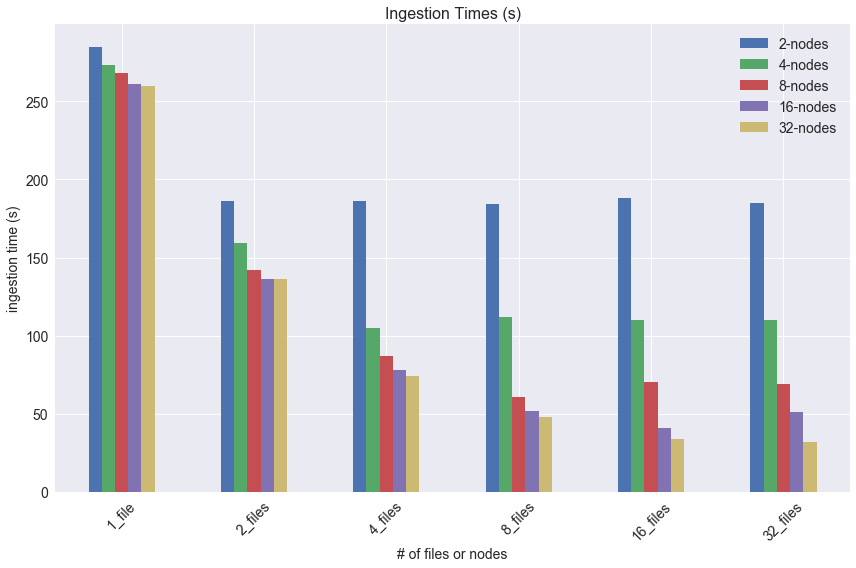

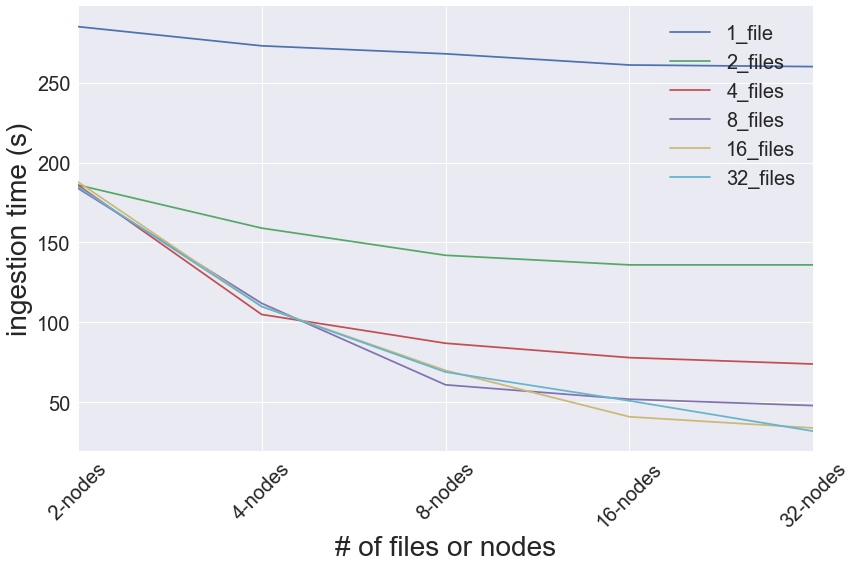

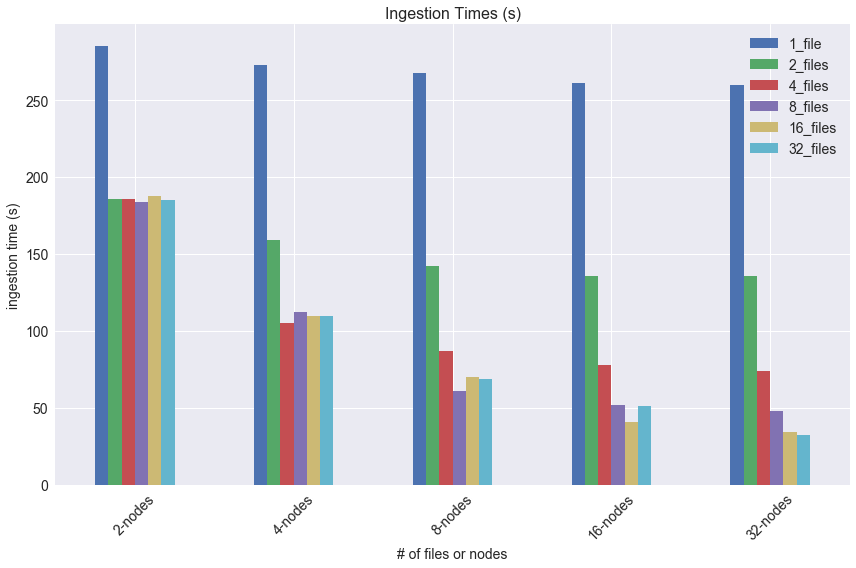

In [9]:
plot_heatmap(ingest_times.drop([2, 3, 4, 7, 9]).set_index('data'))
plot_line(ingest_times.drop([2, 3, 4, 7, 9]))
plot_bar(ingest_times.drop([2, 3, 4, 7, 9]))
plot_line(ingest_times_transpose[[0, 1, 2, 6, 7, 9, 11]], 20, 28, 20, 20)
plt.savefig('FigX_for_presentation.png')
plot_bar(ingest_times_transpose[[0, 1, 2, 6, 7, 9, 11]])


### Visualize special case 2_files

In [22]:
ingest_times.drop([0, 5, 6, 7, 8, 9, 10])


,data,2-nodes,4-nodes,8-nodes,16-nodes,32-nodes
1,2_files,186,159,142,136,136
2,2_files_alternating,186,158,140,138,137
3,2_files_random,186,157,146,136,134
4,2_files_uneven,220,196,185,178,177


In [23]:
ingest_times_transpose[[0, 2, 3, 4, 5]]


,data,2_files,2_files_alternating,2_files_random,2_files_uneven
0,2-nodes,186,186,186,220
1,4-nodes,159,158,157,196
2,8-nodes,142,140,146,185
3,16-nodes,136,138,136,178
4,32-nodes,136,137,134,177


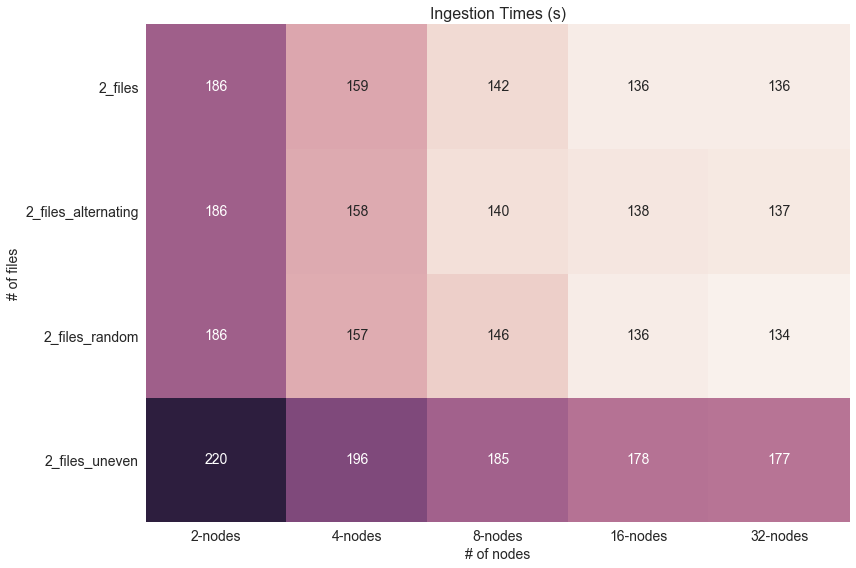

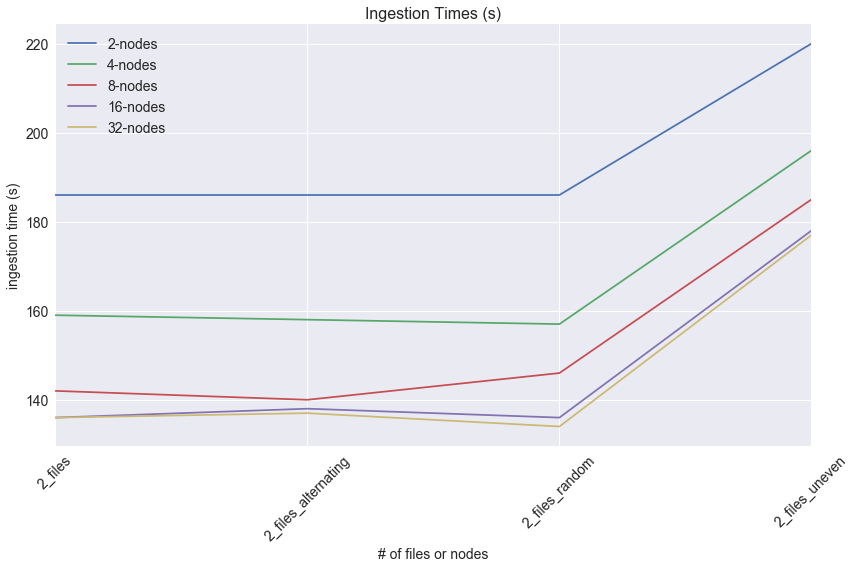

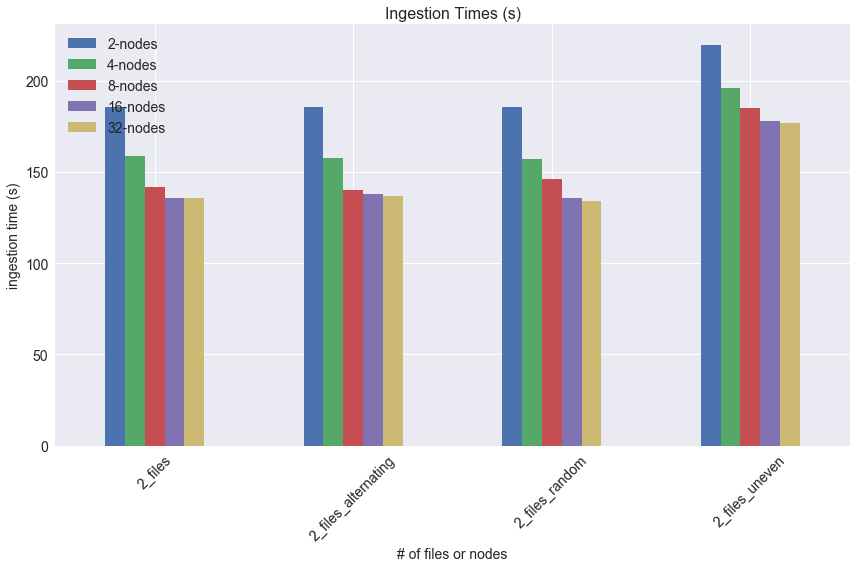

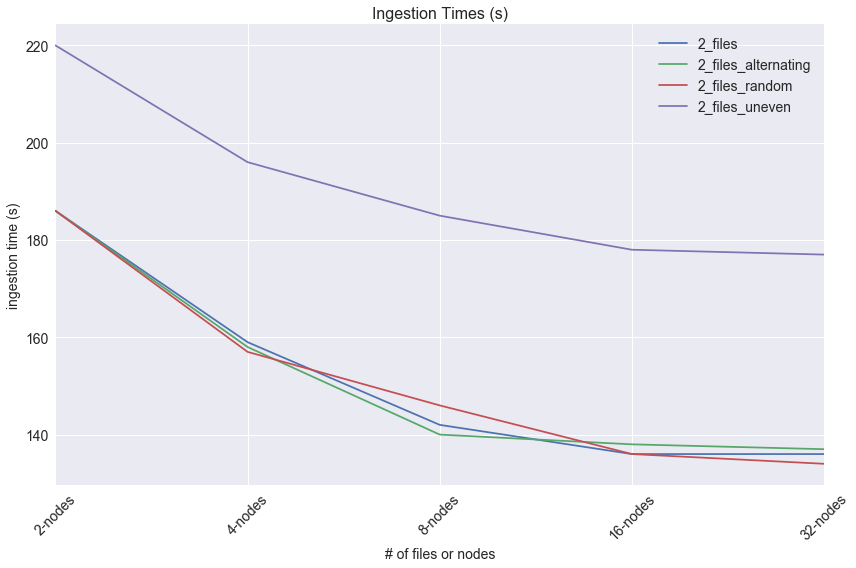

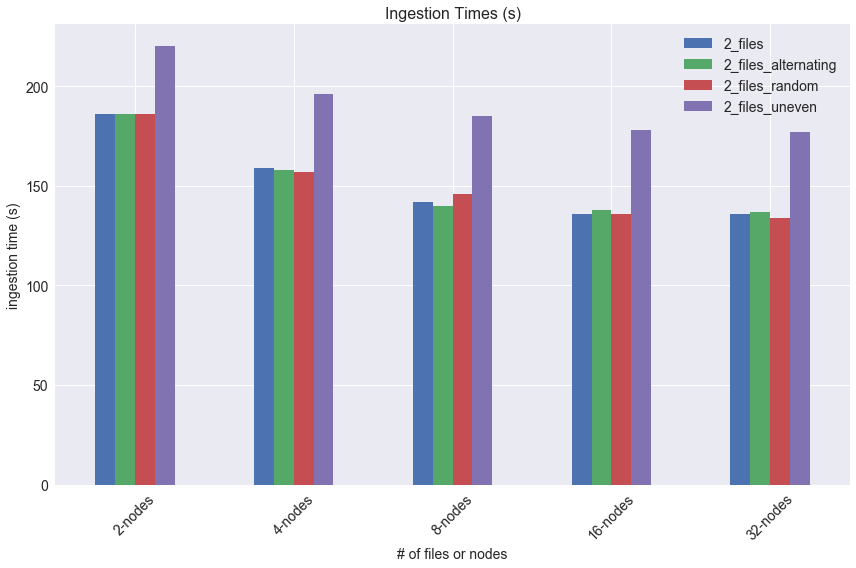

In [24]:
plot_heatmap(ingest_times.drop([0, 5, 6, 7, 8, 9, 10]).set_index('data'))
plot_line(ingest_times.drop([0, 5, 6, 7, 8, 9, 10]))
plot_bar(ingest_times.drop([0, 5, 6, 7, 8, 9, 10]))
plot_line(ingest_times_transpose[[0, 2, 3, 4, 5]])
plot_bar(ingest_times_transpose[[0, 2, 3, 4, 5]])


### Visualize special case 15_files, 16_files and 17_files

In [25]:
ingest_times.drop([0, 1, 2, 3, 4, 5, 6, 10])


,data,2-nodes,4-nodes,8-nodes,16-nodes,32-nodes
7,15_files,195,113,71,41,34
8,16_files,188,110,70,41,34
9,17_files,184,114,81,51,33


In [26]:
ingest_times_transpose[[0, 8, 9, 10]]


,data,15_files,16_files,17_files
0,2-nodes,195,188,184
1,4-nodes,113,110,114
2,8-nodes,71,70,81
3,16-nodes,41,41,51
4,32-nodes,34,34,33


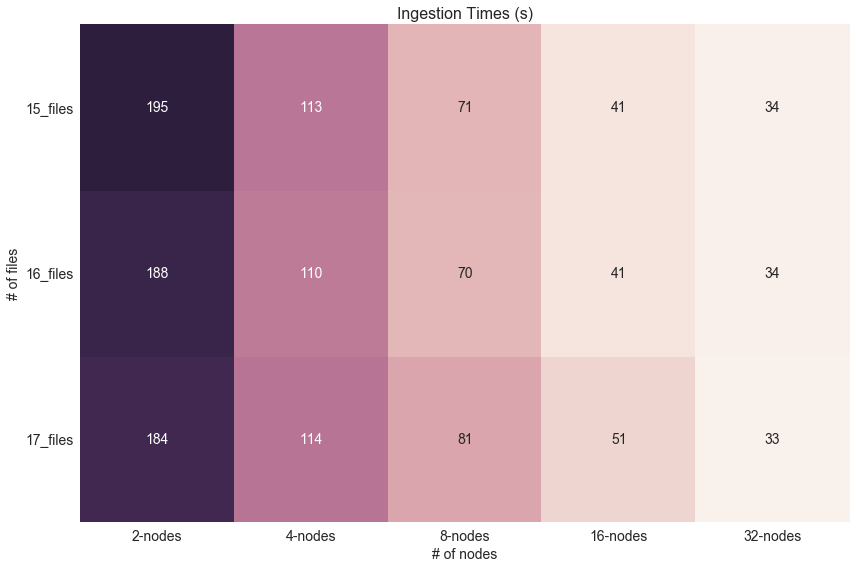

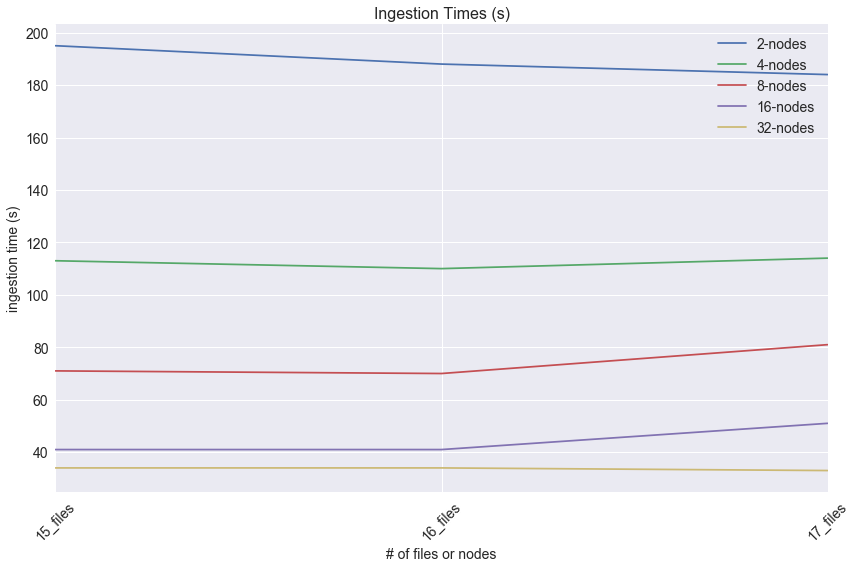

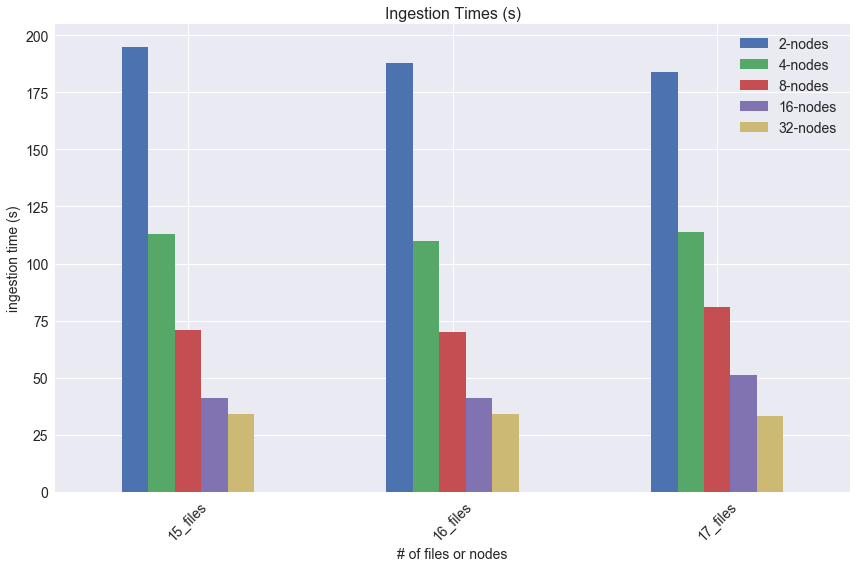

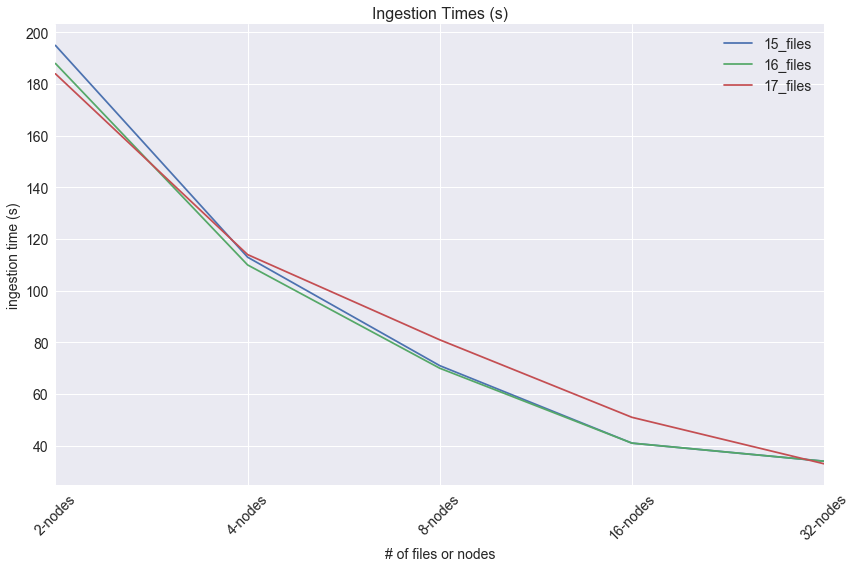

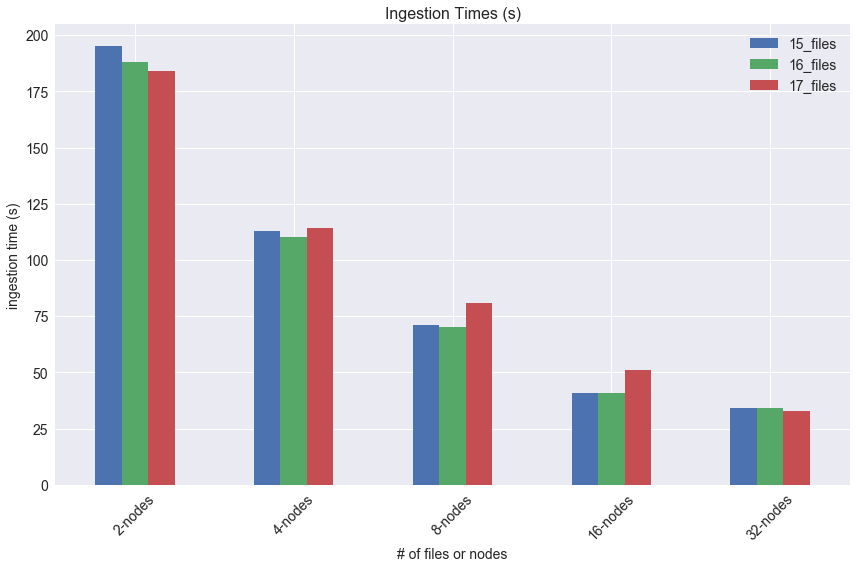

In [27]:
plot_heatmap(ingest_times.drop([0, 1, 2, 3, 4, 5, 6, 10]).set_index('data'))
plot_line(ingest_times.drop([0, 1, 2, 3, 4, 5, 6, 10]))
plot_bar(ingest_times.drop([0, 1, 2, 3, 4, 5, 6, 10]))
plot_line(ingest_times_transpose[[0, 8, 9, 10]])
plot_bar(ingest_times_transpose[[0, 8, 9, 10]])
